<a href="https://colab.research.google.com/github/apolanco3225/MovieRecommendation/blob/main/ModelBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
# install graphml dl libraries
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
fatal: destination path 'cs224w-project-data' already exists and is not an empty directory.


# Data Reading


In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
device

device(type='cpu')

In [76]:
data = pd.read_csv(
    "data/ml-100k/u.data",
    sep="\t",
    names = ["user_id", "movie_id", "rate" ,"timestamp"]
)

data.head()

,user_id,movie_id,rate,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Data Exploration

In [77]:
print(f"Data dimensions. Samples: {data.shape[0]} and Columns: {data.shape[1]}")
print(f"Total number of users: {len(data.user_id.unique())}")
print(f"Total number of movies: {len(data.movie_id.unique())}")
print(f"Rating distribution:\n{data.rate.value_counts()[[1, 2, 3, 4, 5]]}",)

Data dimensions. Samples: 100000 and Columns: 4
Total number of users: 943
Total number of movies: 1682
Rating distribution:
1     6110
2    11370
3    27145
4    34174
5    21201
Name: rate, dtype: int64


Filter movies with good rates

In [78]:
data = data.query("rate >= 3")

In [79]:
print(f"Data dimensions. Samples: {data.shape[0]} and Columns: {data.shape[1]}")
print(f"Total number of users: {len(data.user_id.unique())}")
print(f"Total number of movies: {len(data.movie_id.unique())}")
print(f"Rating distribution:\n{data.rate.value_counts()[[3, 4, 5]]}",)

Data dimensions. Samples: 82520 and Columns: 4
Total number of users: 943
Total number of movies: 1574
Rating distribution:
3    27145
4    34174
5    21201
Name: rate, dtype: int64


# Data Partition

In [80]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2)
print(f"Length train data: {len(train_data)}")
print(f"Length test data: {len(test_data)}")

Length train data: 66016
Length test data: 16504


In [81]:
train_data = train_data.reset_index()
test_data = test_data.reset_index()

# Data Encoding

In [82]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

Detect users and movies that appear both in training and testing sets:

In [83]:
user_mask = test_data.user_id.isin(train_data.user_id.unique())
movie_mask = test_data.movie_id.isin(train_data.movie_id.unique())
user_and_movie_mask = (user_mask & movie_mask)

Filter test dataset with users and movies that are present in training:

In [84]:
test_data = test_data[user_and_movie_mask]

Encoding users and movies in training set:

In [85]:
train_data.loc[:, "user_id"] = user_encoder.fit_transform(train_data.user_id)
train_data.loc[:, "movie_id"] = movie_encoder.fit_transform(train_data.movie_id)

Encoding of users and movies from testing set using encoders from training set.

In [86]:
test_data.loc[:, "user_id"] = user_encoder.transform(test_data.user_id)
test_data.loc[:, "movie_id"] = movie_encoder.transform(test_data.movie_id)

# Data Processing


In [87]:
num_users = len(train_data.user_id.unique())
num_movies = len(train_data.movie_id.unique())

print(f"Unique users: {num_users} Unique movies: {num_movies}")

Unique users: 943 Unique movies: 1542


In [88]:
users_nodes = torch.LongTensor(train_data.user_id)
# add the num of users to the items value so both sets
# won't have node ids that overlap
movies_nodes = torch.LongTensor(train_data.movie_id) + num_users

In [89]:
train_edge_connections = torch.stack(
    (
        torch.cat([users_nodes, movies_nodes]),
        torch.cat([movies_nodes, users_nodes])
    )
).to(device)

print(train_edge_connections)

tensor([[  63,  452,  670,  ..., 1169, 1550, 1002],
        [1023, 1587, 1126,  ...,  221,  338,  888]])


# Model Definition


In [90]:
# data loading

import random

def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id')['movie_id'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id', right_on = 'users')
    pos_items = interected_items_df['movie_id'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['movie_id'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_data, 16, num_users, num_movies)

(tensor([ 11,  17,  66, 120, 177, 254, 325, 515, 571, 590, 601, 641, 664, 695,
         716, 784]),
 tensor([1075, 1519, 1679, 1653, 1168, 1699, 1031, 1298, 2098, 1424, 1067, 1856,
         1368, 1256,  992, 1243]),
 tensor([2469, 1368, 1195, 2142, 1549, 1660, 2019, 2253, 1109, 1973, 1504, 2187,
         1767, 1386,  943, 1954]))

In [91]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [92]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

In [93]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF'
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

In [94]:
# loss function
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [95]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_data['user_id'].values),
    torch.LongTensor(train_data['movie_id'].values)
  ))
  v = torch.ones((len(train_data)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item
  # interactions
  test_interacted_items = test_data.groupby('user_id')['movie_id'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.movie_id, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['movie_id']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()

# Model Training

In [96]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [97]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train_data)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, num_users, num_movies)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_connections)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_connections)
          final_user_Embed, final_item_Embed = torch.split(out, (num_users, num_movies))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, num_users, num_movies, train_data, test_data, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

In [98]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=num_users,
  num_items=num_movies,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2485, 64])]


In [99]:
from tqdm import tqdm

light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(
    lightgcn,
    optimizer,
    train_data
)

100%|██████████| 50/50 [15:44<00:00, 18.90s/it]


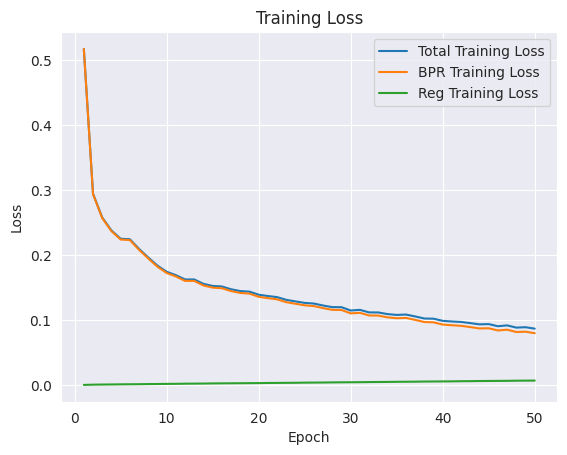

In [112]:
import seaborn as sns
sns.set_style("darkgrid")

epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.title("Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

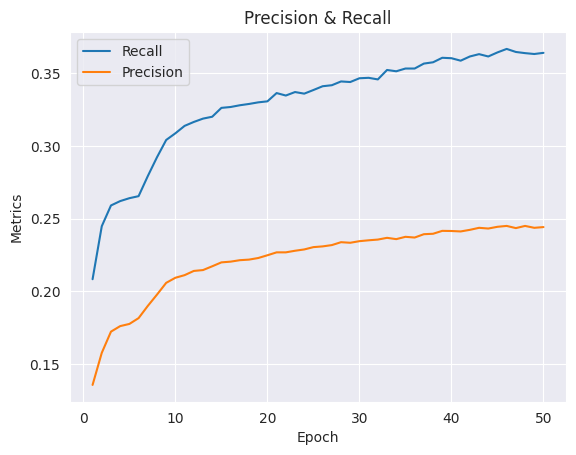

In [113]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')

plt.title("Precision & Recall")
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)

In [107]:
print("Model's state_dict:")
for param_tensor in lightgcn.state_dict():
    print(param_tensor, "\t", lightgcn.state_dict()[param_tensor].size())

Model's state_dict:
embedding.weight 	 torch.Size([2485, 64])


In [108]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'step': tensor(3200.), 'exp_avg': tensor([[ 2.0832e-06,  1.0134e-06, -3.0855e-07,  ..., -4.0415e-06,
         -1.2107e-06, -2.3232e-06],
        [ 1.1663e-06, -4.0330e-06,  2.1751e-06,  ...,  4.5385e-06,
         -1.4065e-06,  1.7714e-06],
        [-2.7170e-06, -2.5418e-07,  1.1626e-06,  ...,  1.1866e-06,
          1.8331e-07,  1.1783e-06],
        ...,
        [ 5.2426e-07,  1.8795e-07,  7.4374e-07,  ..., -4.4641e-08,
         -7.1636e-07, -3.1969e-07],
        [-1.2517e-07,  5.7737e-07, -4.9759e-07,  ..., -3.7033e-07,
          5.7799e-07,  8.5972e-08],
        [ 7.0880e-07, -2.3709e-07, -2.0497e-07,  ..., -7.6091e-07,
         -5.1895e-08,  2.2767e-07]]), 'exp_avg_sq': tensor([[8.3817e-10, 8.4009e-10, 5.2067e-10,  ..., 6.7457e-10, 5.0451e-10,
         3.8209e-10],
        [1.6469e-10, 1.3557e-10, 1.6261e-10,  ..., 4.3817e-10, 1.0312e-10,
         1.6054e-10],
        [2.4398e-10, 3.2299e-10, 1.1044e-10,  ..., 2.9645e-10, 7.5997e-11,
         1.23

In [111]:
model_path = "model/recommender.pkl"
torch.save(lightgcn.state_dict(), model_path)